# Georgian Digital Alphabet Recognition

### Preprocessing
add useful imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
%matplotlib inline

turns a number to a one hot array

In [2]:
def to_one_hot(values: np.ndarray, max: int) -> np.matrix:
    one_hot = np.zeros((values.size, max))
    rows = np.arange(values.size)
    one_hot[rows, values] = 1    

    return one_hot

import image data

In [3]:
import matplotlib.image as im

X_arr = list[np.ndarray]()
Y_arr = list[int]()
num_chars = ord("ჰ") - ord("ა") + 1

for i in range(num_chars):
    char = chr(ord("ა") + i)    # ger character

    file_path_1 = f"data_train/Letters/{char}"
    file_path_2 = f"data_train/images/{char}"

    # import first data
    for image in os.listdir(file_path_1):
        img_data = im.imread(f"{file_path_1}/{image}").ravel()

        X_arr.append(np.append(img_data, np.ones(10000 - len(img_data))))
        Y_arr.append(i)
    
    # import second data
    for image in os.listdir(file_path_2):
        img_data = im.imread(f"{file_path_2}/{image}").ravel()

        X_arr.append(np.append(img_data, np.ones(10000 - len(img_data))))
        Y_arr.append(i)

turn list of image values to numpy matrix, values to one_hot vector

In [4]:
X = np.asmatrix(X_arr)
Y = to_one_hot(np.asarray(Y_arr), num_chars)    # convert 33 characters to one_hot array

X.shape, Y.shape

((96897, 10000), (96897, 33))

divide data to train, validation, and test

In [5]:
division_points = (int(X.shape[0] * 0.6), int(X.shape[0] * 0.8))

data = np.append(X, Y, 1)
np.random.shuffle(data)

X = data[:, 0: X.shape[1]]
Y = data[:, X.shape[1]:]

X_train = X[0: division_points[0], :]
Y_train = Y[0: division_points[0], :]

X_valid = X[division_points[0]: division_points[1], :]
Y_valid = Y[division_points[0]: division_points[1], :]

X_test = X[division_points[1]:, :]
Y_test = Y[division_points[1]:, :]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape

((58138, 10000),
 (58138, 33),
 (19379, 10000),
 (19379, 33),
 (19380, 10000),
 (19380, 33))

add normalizarion to the three datas seperately

In [6]:
X_train_mean = X_train.mean(0)

X_train -= X_train_mean
X_valid -= X_train_mean
X_test -= X_train_mean

##### Reduce dimensions using PCA for data compression reasons
find minimum dimension to reduce data to

start from 0 and raise dimension, until reduced dimension retaines 99% of the original varinace

In [7]:
min_dimension = 0

sigma = (1 / X_train.shape[0]) * X.T * X
u, s, _ = np.linalg.svd(sigma)

dimension_sum = 0
full_sum = np.sum(s)

for k in range(len(s)):
    dimension_sum += s[k]
    variance_retained = dimension_sum / full_sum

    if variance_retained > 0.99:
        min_dimension = k
        break

In [8]:
min_dimension

2344

reduce data

In [9]:
u_reduce = u[:, : min_dimension]

X_train = X_train * u_reduce
X_valid = X_valid * u_reduce
X_test = X_test * u_reduce

X_train.shape, X_valid.shape, X_test.shape

((58138, 2344), (19379, 2344), (19380, 2344))

### Build a model
build a model using tensorFlow and Keras libraries

In [10]:
from typing import Optional

def get_model(alpha: float, lambd: Optional[float] = 0) -> tf.keras.Sequential:
    # l2 regulizer - sum(square(x))
    from tensorflow.keras.regularizers import l2

    # model with 4 layers
    # Input layer with {min_dimension} nodes
    # 2 hidden layers with "ReLU" activation function and 256 nodes
    # Output layer with "SoftMax" activation function and {num_chars} or 33 layers
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=min_dimension),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(l=lambd)),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(l=lambd)),
        tf.keras.layers.Dense(num_chars, activation='softmax', kernel_regularizer=l2(l=lambd))
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=alpha), 
        loss='categorical_crossentropy',    # cost function
        metrics=['accuracy']                # statistics to keep track of
    )

    return model

##### draw the graph of model costs to choose the best alpha

In [11]:
alpha = 0.001   # Manually select the best alpha acording to the cost function graph

model = get_model(alpha)

history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))
loss = history.history['loss']

2022-02-08 23:42:41.419978: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
1817/1817 [==============================] - 7s 4ms/step - loss: 1.3139 - accuracy: 0.6403 - val_loss: 0.9000 - val_accuracy: 0.7464
Epoch 2/10
1817/1817 [==============================] - 6s 3ms/step - loss: 0.5953 - accuracy: 0.8256 - val_loss: 0.8114 - val_accuracy: 0.7779
Epoch 3/10
1817/1817 [==============================] - 6s 3ms/step - loss: 0.3579 - accuracy: 0.8920 - val_loss: 0.8263 - val_accuracy: 0.7946
Epoch 4/10
1817/1817 [==============================] - 6s 3ms/step - loss: 0.2425 - accuracy: 0.9254 - val_loss: 0.9082 - val_accuracy: 0.7992
Epoch 5/10
1817/1817 [==============================] - 6s 3ms/step - loss: 0.1802 - accuracy: 0.9436 - val_loss: 1.0225 - val_accuracy: 0.8015
Epoch 6/10
1817/1817 [==============================] - 6s 3ms/step - loss: 0.1522 - accuracy: 0.9545 - val_loss: 1.0902 - val_accuracy: 0.8069
Epoch 7/10
1817/1817 [==============================] - 6s 3ms/step - loss: 0.1239 - accuracy: 0.9623 - val_loss: 1.2294 - val_accuracy:

Text(0.5, 1.0, 'Error vs. Training Epoch')

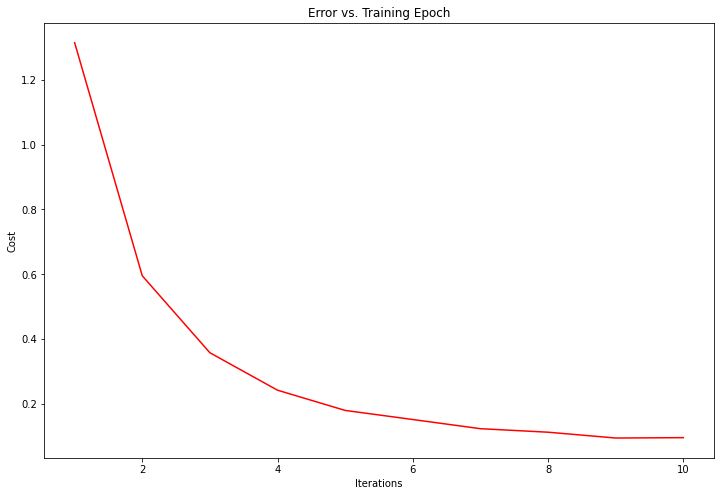

In [12]:
vfig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(len(loss)) + 1, loss, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')

##### Choose the number of epochs based on validation data

In [13]:
epochs_list = list(range(1, 13))
errors_train = np.zeros(len(epochs_list))
errors_valid = np.zeros(len(epochs_list))

for i, epoch_num in enumerate(epochs_list):
    model = get_model(alpha)
    history = model.fit(X_train, Y_train, epochs=epoch_num, validation_data=(X_valid, Y_valid))

    train_loss = history.history['accuracy'][-1]
    valid_loss = history.history['val_accuracy'][-1]

    errors_train[i] = 1 - train_loss
    errors_valid[i] = 1 - valid_loss

    print(f"{i + 1} / {len(epochs_list)}")

1817/1817 [==============================] - 8s 4ms/step - loss: 1.3145 - accuracy: 0.6421 - val_loss: 0.8860 - val_accuracy: 0.7503
1 / 12
Epoch 1/2
1817/1817 [==============================] - 8s 4ms/step - loss: 1.3207 - accuracy: 0.6398 - val_loss: 0.9060 - val_accuracy: 0.7469
Epoch 2/2
1817/1817 [==============================] - 7s 4ms/step - loss: 0.5990 - accuracy: 0.8248 - val_loss: 0.7872 - val_accuracy: 0.7858
2 / 12
Epoch 1/3
1817/1817 [==============================] - 8s 4ms/step - loss: 1.3156 - accuracy: 0.6413 - val_loss: 0.8797 - val_accuracy: 0.7543
Epoch 2/3
1817/1817 [==============================] - 7s 4ms/step - loss: 0.5963 - accuracy: 0.8261 - val_loss: 0.8239 - val_accuracy: 0.7765
Epoch 3/3
1817/1817 [==============================] - 8s 4ms/step - loss: 0.3612 - accuracy: 0.8907 - val_loss: 0.8426 - val_accuracy: 0.7929
3 / 12
Epoch 1/4
1817/1817 [==============================] - 8s 4ms/step - loss: 1.3162 - accuracy: 0.6414 - val_loss: 0.8910 - val_accur

choose best epoch according to cross-validation accuracy

In [14]:
epochs = epochs_list[errors_valid.argmin()]
epochs

8

Text(0.5, 1.0, 'Error vs. Lambda Value')

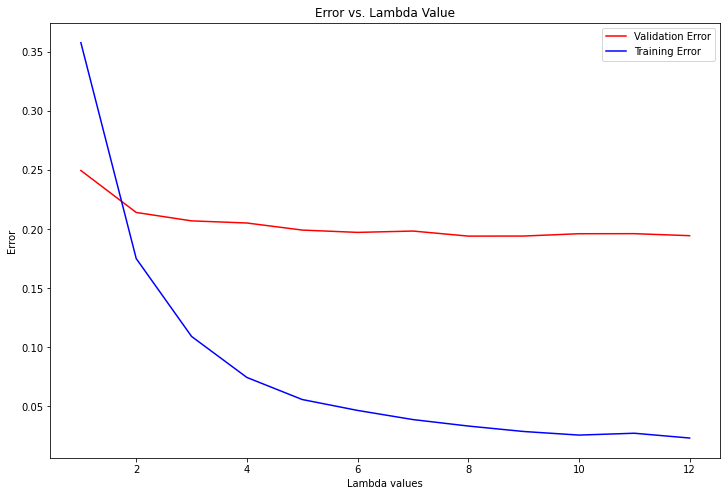

In [15]:
vfig, ax = plt.subplots(figsize=(12,8))
ax.plot(epochs_list, errors_valid, 'r', label="Validation Error")
ax.plot(epochs_list, errors_train, 'b', label="Training Error")
ax.legend(loc=1)
ax.set_xlabel('Lambda values')
ax.set_ylabel('Error')
ax.set_title('Error vs. Lambda Value')

##### choose optimal lambda for the model
generate 12 different lambda values (including 0)

In [16]:
lambdas: list[float] = [0]

lambd = 0.0001
while len(lambdas) < 10:
    lambdas.append(lambd)
    
    lambd *= 2

train model on different regularization parameters and choose the one that performes best on cross-validation data

In [17]:
errors_train = np.zeros(len(lambdas))
errors_valid = np.zeros(len(lambdas))
models: list[tf.keras.Sequential] = []

for i, lambd in enumerate(lambdas):
    model = get_model(alpha, lambd)
    history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid))
    models.append(model)

    train_loss = history.history['accuracy'][-1]
    valid_loss = history.history['val_accuracy'][-1]

    errors_train[i] = 1 - train_loss
    errors_valid[i] = 1 - valid_loss

    print(f"{i + 1} / {len(lambdas)}")

Epoch 1/8
1817/1817 [==============================] - 7s 4ms/step - loss: 1.3068 - accuracy: 0.6430 - val_loss: 0.8776 - val_accuracy: 0.7537
Epoch 2/8
1817/1817 [==============================] - 7s 4ms/step - loss: 0.5970 - accuracy: 0.8263 - val_loss: 0.8078 - val_accuracy: 0.7792
Epoch 3/8
1817/1817 [==============================] - 7s 4ms/step - loss: 0.3605 - accuracy: 0.8922 - val_loss: 0.8243 - val_accuracy: 0.7956
Epoch 4/8
1817/1817 [==============================] - 6s 4ms/step - loss: 0.2434 - accuracy: 0.9256 - val_loss: 0.9268 - val_accuracy: 0.7982
Epoch 5/8
1817/1817 [==============================] - 7s 4ms/step - loss: 0.1866 - accuracy: 0.9426 - val_loss: 1.0599 - val_accuracy: 0.7929
Epoch 6/8
1817/1817 [==============================] - 7s 4ms/step - loss: 0.1479 - accuracy: 0.9557 - val_loss: 1.0861 - val_accuracy: 0.8039
Epoch 7/8
1817/1817 [==============================] - 7s 4ms/step - loss: 0.1248 - accuracy: 0.9636 - val_loss: 1.1910 - val_accuracy: 0.8029

get the best lambda and the best model acording to the cross-validation accuracy

In [18]:
lambd = lambdas[errors_valid.argmin()]
model = models[errors_valid.argmin()]
lambd

0.0002

Text(0.5, 1.0, 'Error vs. Lambda Value')

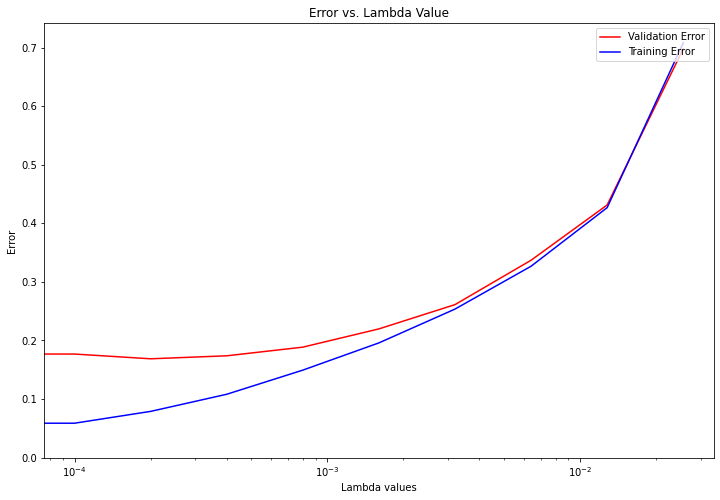

In [19]:
vfig, ax = plt.subplots(figsize=(12,8))
ax.set_xscale('log') # lambdas grow exponentially, logarithmic scales makes it easier to view the change in distances
ax.plot(lambdas, errors_valid, 'r', label="Validation Error")
ax.plot(lambdas, errors_train, 'b', label="Training Error")
ax.legend(loc=1)
ax.set_xlabel('Lambda values')
ax.set_ylabel('Error')
ax.set_title('Error vs. Lambda Value')

##### debug model using learning curves

In [20]:
errors_train = np.zeros(10)
errors_valid = np.zeros(10)

for i in range(10):
    X_train_div = X_train[0: int(((i + 1) * X_train.shape[0]) / 10), :]
    Y_train_div = Y_train[0: int(((i + 1) * Y_train.shape[0]) / 10), :]
    X_valid_div = X_valid[0: int(((i + 1) * X_valid.shape[0]) / 10), :]
    Y_valid_div = Y_valid[0: int(((i + 1) * Y_valid.shape[0]) / 10), :]

    model = get_model(alpha, lambd)
    history = model.fit(X_train_div, Y_train_div, epochs=epochs, validation_data=(X_valid_div, Y_valid_div))

    train_accuracy = history.history['accuracy'][-1]
    valid_accuracy = history.history['val_accuracy'][-1]

    errors_train[i] = 1 - train_accuracy
    errors_valid[i] = 1 - valid_accuracy

    print(f"{i + 1} / 10")    

Epoch 1/8
182/182 [==============================] - 1s 5ms/step - loss: 2.8122 - accuracy: 0.3155 - val_loss: 2.0224 - val_accuracy: 0.5034
Epoch 2/8
182/182 [==============================] - 1s 4ms/step - loss: 1.2317 - accuracy: 0.7244 - val_loss: 1.8009 - val_accuracy: 0.5803
Epoch 3/8
182/182 [==============================] - 1s 4ms/step - loss: 0.6865 - accuracy: 0.8856 - val_loss: 1.8844 - val_accuracy: 0.5916
Epoch 4/8
182/182 [==============================] - 1s 4ms/step - loss: 0.4846 - accuracy: 0.9388 - val_loss: 1.9903 - val_accuracy: 0.5891
Epoch 5/8
182/182 [==============================] - 1s 4ms/step - loss: 0.3976 - accuracy: 0.9668 - val_loss: 2.0814 - val_accuracy: 0.5906
Epoch 6/8
182/182 [==============================] - 1s 4ms/step - loss: 0.3365 - accuracy: 0.9766 - val_loss: 2.1296 - val_accuracy: 0.6020
Epoch 7/8
182/182 [==============================] - 1s 4ms/step - loss: 0.3021 - accuracy: 0.9845 - val_loss: 2.1735 - val_accuracy: 0.5999
Epoch 8/8
182

Text(0.5, 1.0, 'Error vs. Data Size')

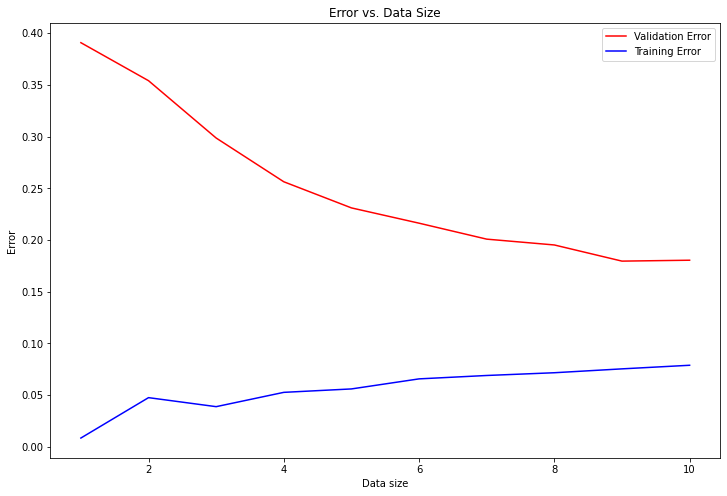

In [21]:
vfig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(10) + 1, errors_valid, 'r', label="Validation Error")
ax.plot(np.arange(10) + 1, errors_train, 'b', label="Training Error")
ax.legend(loc=1)
ax.set_xlabel('Data size')
ax.set_ylabel('Error')
ax.set_title('Error vs. Data Size')

In [22]:
def predict(predictions: np.matrix) -> np.matrix:
    return to_one_hot(np.asarray(predictions.argmax(axis=1)).ravel(), num_chars)

In [23]:
def get_accuracy(model: tf.keras.Sequential, X: np.matrix, Y: np.matrix) -> float:
    return (predict(model.predict(X)) == Y).all(axis=1).mean()

In [28]:
get_accuracy(model, X_train, Y_train)

0.9420344697100004

Save neural network model, saved data as a folder

In [31]:
model.save("./andria_kilasonia_nn_model")

2022-02-09 00:19:54.454731: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./andria_kilasonia_nn_model/assets


Save data reduction matrix

In [32]:
np.save('andria_kilasonia_reduce_matrix.npy', u_reduce)

Save mean of the training data to normilize new inputs

In [34]:
np.save("andria_kilasonia_data_mean.npy", X_train_mean)